In [7]:
import matplotlib.pyplot as plt
from config import settings

import pymongo
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['font.size'] = 25

# db = pymongo.MongoClient("mongodb://localhost:27017/")['Jan16_cloudseg_saliency_loss']
db = pymongo.MongoClient("mongodb://localhost:27017/")['Feb12_encoding_x264']

In [4]:
approach1 = 'backprop_sigmoid_saliency_error_add_preset_lr_0.1_9sec'
approach2 = 'chameleon'

No handles with labels found to put in legend.


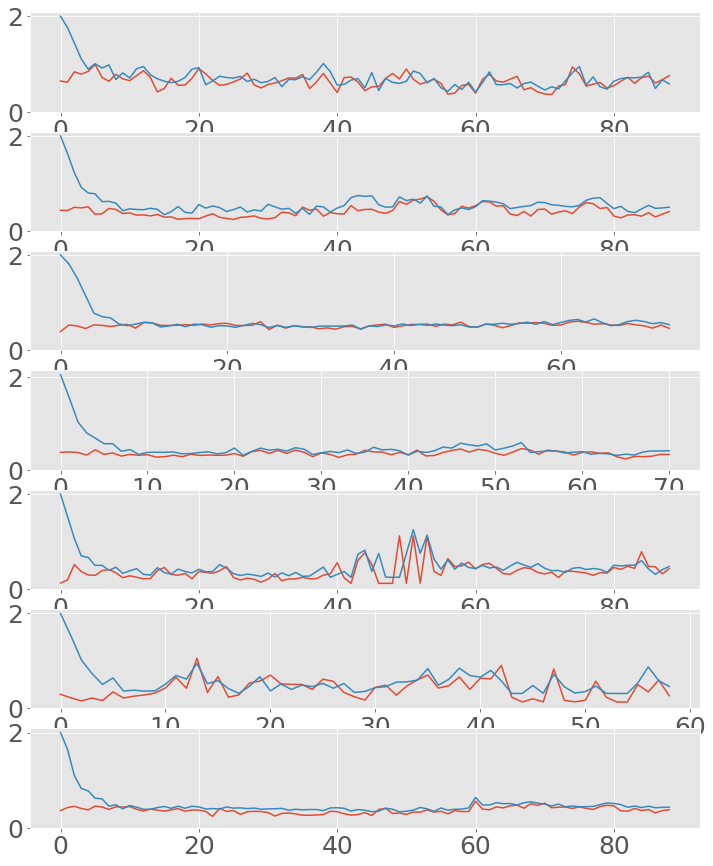

In [5]:


import numpy as np
fmts = [f'videos/yoda/dashcam_{i}/part%d.mp4' for i in [1,2,3,4,5,6,7,8]]
def query_approach(ax, approach, label, fmt, column='stats'):
    f1s = []

    try:

        for sec in range(0, 1000):

            query = {
                'second': sec,
                'command_line_args.approach': approach,
                'command_line_args.input': fmt,
            }

            x = list(db['stats'].find(query))
            x = sorted(x, key = lambda x: x['_id'])
            f1s.append(x[-1])

    except IndexError:
        pass



    ax.plot(range(len(f1s)), [1 - i['f1'] \
        + settings.backprop.bw_weight * i['norm_bw'] \
            + settings.backprop.compute_weight * len(i['encoded_frames'])/10 for i in f1s], label=label)
    
    # ax[1].plot(range(len(f1s)), [i['f1'] for i in f1s], label=label)
    

fig, axs = plt.subplots(7, figsize=(12, 15))
j = 0
for i in range(8):
    if i == 2:
        continue
    query_approach(axs[j], approach2, 'Baseline', fmts[i])
    query_approach(axs[j], approach1, 'Ours', fmts[i])
    axs[j].set_ylim(bottom=0)
    # axs[j].legend()
    j += 1
# query_approach(ax, approach3, 'Cheat')

ax.legend()

0.0648665301529331 0.7293657311274729
0.08506145258921027 0.789334231188738


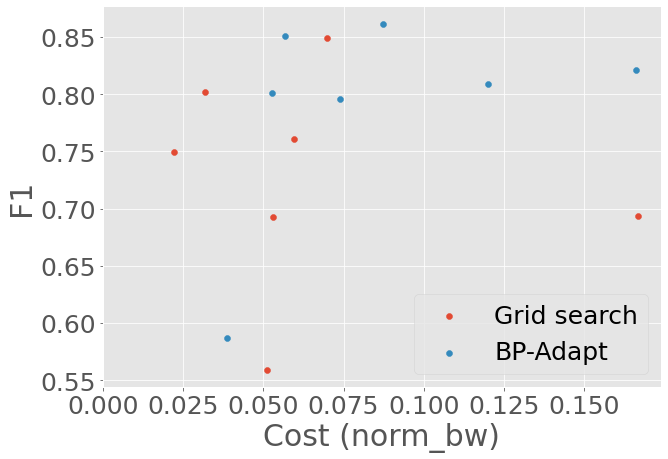

In [9]:
def calc_cost_chameleon(approach, fmt, cost_key='compute'):
    
    costs = []

    try:

        for sec in range(0, 1000):

            if sec < 9:
                continue

            query = {
                'second': sec,
                'command_line_args.approach': approach,
                'command_line_args.input': fmt,
            }

            x = list(db['cost'].find(query))
            x = sorted(x, key = lambda x: x['_id'])
            costs.append(x[-1])

    except IndexError:
        pass
    
    return np.mean([i[cost_key] for i in costs])

def calc_cost_backprop(approach, fmt, cost_key='compute'):
    
    costs = []

    try:

        for sec in range(0, 1000):

            if sec < 9:
                continue
            
            query = {
                'second': sec,
                'command_line_args.approach': approach,
                'command_line_args.input': fmt,
            }

            x = list(db['stats'].find(query))
            x = sorted(x, key = lambda x: x['_id'])
            costs.append(x[-1])
            
            if sec % 3 == 0 and sec < 20:
                costs[-1]['compute'] = len(costs[-1]['encoded_frames']) / 10 + 0.1
            else:
                costs[-1]['compute'] = len(costs[-1]['encoded_frames']) / 10

    except IndexError:
        pass
    
    return np.mean([i[cost_key] for i in costs])

fig, ax = plt.subplots(figsize=(10, 7))

compute, bw, acc = [], [], []
for idx, fmt in enumerate(fmts):
    if idx == 2:
        continue
    compute.append(calc_cost_chameleon('chameleon', fmt))
    bw.append(calc_cost_chameleon('chameleon', fmt, cost_key = 'norm_bw'))
    acc.append(calc_cost_chameleon('chameleon', fmt, cost_key = 'f1'))

ax.scatter([j for i,j in zip(bw, compute)], acc, label='Grid search')

print(np.mean([j for i,j in zip(bw, compute)]), np.mean(acc))


compute, bw, acc = [], [], []
for idx, fmt in enumerate(fmts):
    if idx == 2:
        continue
    compute.append(calc_cost_backprop(approach1, fmt))
    bw.append(calc_cost_backprop(approach1, fmt, cost_key='norm_bw'))
    acc.append(calc_cost_backprop(approach1, fmt, cost_key='f1'))

ax.scatter([j for i,j in zip(bw, compute)], acc, label='BP-Adapt')
print(np.mean([j for i,j in zip(bw, compute)]), np.mean(acc))

ax.set_xlim(left=0)
ax.set_xlabel('Cost (norm_bw)')
ax.set_ylabel('F1')

ax.legend()